In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [2]:
df = pd.read_csv('Synthetic_Movie_Lens/ratings.csv')  
print(df)
a = df['userId'].unique()
b = df['movieId'].unique()
columns =  sorted(a)
rows = sorted(b)

        Unnamed: 0  userId  movieId  rating   timestamp
0                0     496   112852     3.0  1415520462
1                1     391     1947     4.0  1030945141
2                2     387     1562     1.5  1095041022
3                3     474     2716     4.5  1053020930
4                4     483    88125     4.5  1311337237
...            ...     ...      ...     ...         ...
100831      100831     469     1219     4.0   965661925
100832      100832     599     3571     2.0  1498511343
100833      100833     414      276     3.0   961596299
100834      100834     395      168     3.0   841503984
100835      100835     288     2407     3.5  1054568795

[100836 rows x 5 columns]


In [3]:
R = pd.DataFrame(np.nan, index=rows, columns=columns)
for index, row in df.iterrows():
    R[(int(row['userId']))][int(row['movieId'])] = row['rating']
# from scipy.sparse import csr_matrix
# # pivot ratings into movie features
# df_movie_features = df.pivot(
#     index='movieId',
#     columns='userId',
#     values='rating'
# ).fillna(0)
# # convert dataframe of movie features to scipy sparse matrix
# R = csr_matrix(df_movie_features.values)

In [4]:
sparsity = (len(rows)*len(columns) - R.isna().sum().sum())/(len(rows)*len(columns))
print("Sparsity: %0.10f " % (sparsity))

Sparsity: 0.0169996831 


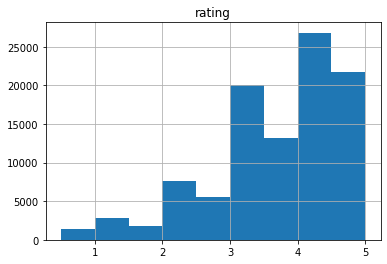

In [6]:
hist = df.hist(column= 'rating', bins=9)

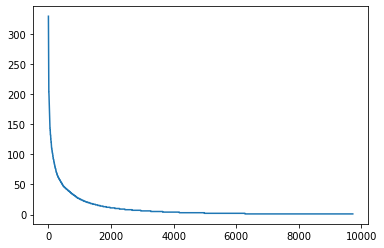

In [7]:
count = df['movieId'].value_counts()
plt.plot(count.values)

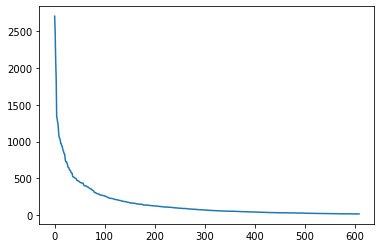

In [8]:
count = df['userId'].value_counts()
plt.plot(count.values)

(array([6.337e+03, 2.444e+03, 7.020e+02, 1.280e+02, 6.800e+01, 3.100e+01,
        7.000e+00, 4.000e+00, 3.000e+00]),
 array([0.    , 0.5625, 1.125 , 1.6875, 2.25  , 2.8125, 3.375 , 3.9375,
        4.5   , 5.0625]),
 <BarContainer object of 9 artists>)

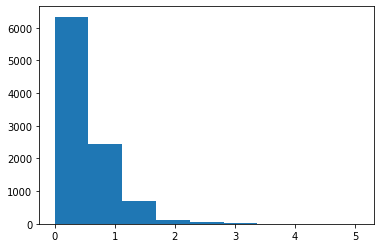

In [9]:
R.var(axis=1)
R_array = np.array(R)
R_var = np.nanvar(R_array, axis=1)
plt.hist(R_var, bins = 9)

In [10]:
from surprise import KNNBasic
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse

In [120]:
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
algorithms = [SVD(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic()]
benchmark = []
print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f699559fca0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f699559fd00>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f699559fc70>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7f69983daac0>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f69983d0a00>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f699559fca0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f699559fca0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f699559fd00>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f699559fd00> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f699559fc70>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f699559fc70> 


Starting:  

In [122]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.881822,2.158573,0.173700
KNNBaseline,0.885318,0.131510,1.432006
NMF,0.934596,2.811319,0.107659
KNNBasic,0.957600,0.038763,1.111392
NormalPredictor,1.422553,0.058646,0.200880


In [12]:
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [14]:
k = 0
results_rmse = []
results_mae = []
sim_options = {
    'name': 'pearson',
    'user_based': 'True'
    }


while 2*k < 100:
    clf = KNNBasic(k=2*k+2, sim_options = sim_options)
#     model = KNNBasic(k=2*k+2)
    result = []
    results = cross_validate(clf, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
    results_rmse.append(results['test_rmse'].mean())
    results_mae.append(results['test_mae'].mean())
    k = k+1

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1185  1.1128  1.1078  1.1029  1.111

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9701  0.9766  0.9639  0.9656  0.9734  0.9691  0.9612  0.9800  0.9772  0.9853  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9678  0.9731  0.9735  0.9836  0.9615  0.9695  0.9532  0.9543  0.9704  0.9645  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9624  0.9672  0.9667  0.9656  0.9559  0.9579  0.9638  0.9640  0.9752  0.9706  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9853  0.9724  0.9553  0.9663  0.9583  0.9562  0.9688  0.9700  0.9467  0.9709  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9593  0.9564  0.9742  0.9612  0.9786  0.9821  0.9646  0.9595  0.9629  0.9608  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9631  0.9573  0.9694  0.9774  0.9531  0.9663  0.9637  0.9698  0.9711  0.9633  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9639  0.9750  0.9566  0.9557  0.9678  0.9722  0.9625  0.9644  0.9686  0.9737  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9613  0.9419  0.9834  0.9612  0.9622  0.9668  0.9693  0.9753  0.9745  0.9606  

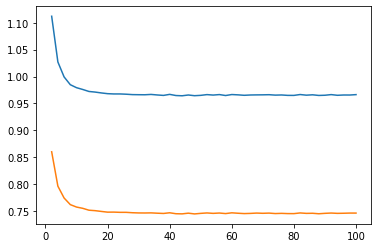

In [15]:
klist = np.linspace(2, 100, 50 )
plt.plot(klist, np.array(results_rmse))
plt.show
plt.plot(klist, np.array(results_mae))

In [16]:
import pickle
 
pickle.dump( results_rmse, open( "result_knn_rmse.pkl", "wb" ) )
pickle.dump( results_mae, open( "result_knn_mae.pkl", "wb" ) )

The average RMSE and average MAE converges to a steady state at approximately k=20.  

In [23]:
print("The average RMSE at k=20 is: %0.7f" % results_rmse[9])
print("The average MAE at k=20 is: %0.7f" % results_mae[9])

The average RMSE at k=20 is: 0.9681449
The average MAE at k=20 is: 0.7480826


`Popular Movie Trimming

In [28]:
from collections import Counter

In [29]:
def PMT(testset):    
    counter = [x for x in Counter([x[1] for x in testset]).items()]
    count_filter = list(filter(lambda x:x[1] > 2,counter))
    testset_trim = list(filter(lambda x:x[1] in [y[0] for y in count_filter],
                           testset))
    return testset_trim

Unpopular Movie Trimming

In [30]:
def UMT(testset):    
    counter = [x for x in Counter([x[1] for x in testset]).items()]
    count_filter = list(filter(lambda x:x[1] <= 2,counter))
    testset_trim = list(filter(lambda x:x[1] in [y[0] for y in count_filter],
                           testset))
    return testset_trim

High Variance Movie Trimming

In [58]:
def get_var(data):
    length = data.shape[0]
    d = {}
    d_key = set(data[:,0])
    for i in d_key:
        li = []
        for j in range(length):
            if i==data[j,0]:
                li.append(float(data[j,1]))
        d_var = np.var(li)
        d[i] = d_var
    return d

In [86]:
def HVMT(testset):
    counter = [x for x in Counter([x[1] for x in testset]).items()]
    count_filter1 = list(filter(lambda x:x[1] >= 5,counter))
    var_list = list(get_var(np.array(testset)[:,1:3]).items())
    count_filter2 = list(filter(lambda x:x[1] >= 2,var_list))
    count_filter = list(set([x[0] for x in count_filter1]).intersection(set([y[0] for y in count_filter2])))
    #count_filter = list([x[0] for x in count_filter1 if x[0] in [y[0] for y in count_filter2]])
    testset_trim = list(filter(lambda x:x[1] in [y for y in count_filter],
                           testset))
    return testset_trim

In [87]:
a = [('0','1',4),('0','1',3),('2','1',2),('2','2',2),('2','3',4),('6','3',3),('6','3',2),
    ('0','1',100),('0','1',20),('5','3',100),('6','3',20)]
HVMT(a)

[('0', '1', 4),
 ('0', '1', 3),
 ('2', '1', 2),
 ('2', '3', 4),
 ('6', '3', 3),
 ('6', '3', 2),
 ('0', '1', 100),
 ('0', '1', 20),
 ('5', '3', 100),
 ('6', '3', 20)]

In [85]:
var_list = list(get_var(np.array(a)[:,1:3]).items())
var_list
counter = [x for x in Counter([x[1] for x in a]).items()]
count_filter1 = list(filter(lambda x:x[1] >= 5,counter))
count_filter2 = list(filter(lambda x:x[1] >= 2,var_list))
count_filter = list(set([x[0] for x in count_filter1]).intersection(set([y[0] for y in count_filter2])))
#count_filter = list([x[0] for x in count_filter1 if x[0] in [y[0] for y in count_filter2]])
testset_trim = list(filter(lambda x:x[1] in [y[0] for y in count_filter],
                       a))
count_filter2
testset_trim

[('0', '1', 4),
 ('0', '1', 3),
 ('2', '1', 2),
 ('2', '3', 4),
 ('6', '3', 3),
 ('6', '3', 2),
 ('0', '1', 100),
 ('0', '1', 20),
 ('5', '3', 100),
 ('6', '3', 20)]

In [32]:
# train the dataset using Popular movie trimming
from surprise.model_selection import KFold
from surprise import accuracy
# define a cross-validation iterator
kf = KFold(n_splits=10)
sim_options = {
    'name': 'pearson',
    'user_based': 'True'
    }


# Construct a knn filter
rmse = []
for k in range(2,100,2):
    clf = KNNBasic(k=k, sim_options = sim_options)
    rmse_i = []
    for trainset, testset in kf.split(data):

        # train and test algorithm.
        clf.fit(trainset)
        testset_trim = PMT(testset)
        predictions = clf.test(testset_trim)

        # Compute and print Root Mean Squared Error
        rmse_i.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(np.mean(rmse_i))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1012
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0929
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0795
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0877
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1184
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0882
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1165
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1060
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0925
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1098
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0032
Computing 

Done computing similarity matrix.
RMSE: 0.9277
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9350
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9268
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9349
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9335
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9178
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9315
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9339
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9412
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9423
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9302
Computing the pearson similarity matrix...
Done compu

RMSE: 0.9396
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9265
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9326
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9293
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9022
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9248
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9317
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9155
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9245
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9043
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.91

Done computing similarity matrix.
RMSE: 0.8991
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9263
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9340
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9353
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9370
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9263
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9087
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9119
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9232
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9347
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9264
Computing the pearson similarity matrix...
Done compu

RMSE: 0.9096
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9357
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9197
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9392
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9147
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9267
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9295
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9176
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9284
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9235
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9303
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.91

Done computing similarity matrix.
RMSE: 0.9327
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9099
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9312
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9315
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9126
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9199
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9365
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9326
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9106
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9236
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9091
Computing the pearson similarity matrix...
Done compu

The minimum average value of RMSE is: 0.9213966405429034


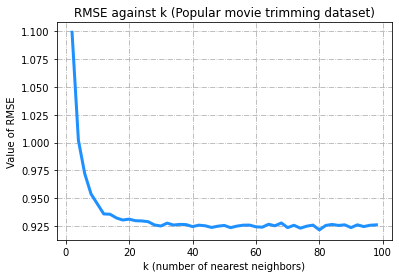

In [33]:
x = range(2,100,2)
plt.plot(x,rmse,color='dodgerblue',linewidth=3)
plt.grid(True,linestyle='-.')
plt.xlabel('k (number of nearest neighbors)')
plt.ylabel('Value of RMSE')
plt.title('RMSE against k (Popular movie trimming dataset)')
print('The minimum average value of RMSE is:',min(rmse))

Unpopular Movie Trimming Dataset

In [34]:
# train the dataset using Popular movie trimming
from surprise.model_selection import KFold
from surprise import accuracy
# define a cross-validation iterator
kf = KFold(n_splits=10)
sim_options = {
    'name': 'pearson',
    'user_based': 'True'
    }


# Construct a knn filter
rmse = []
for k in range(2,100,2):
    clf = KNNBasic(k=k, sim_options = sim_options)
    rmse_i = []
    for trainset, testset in kf.split(data):

        # train and test algorithm.
        clf.fit(trainset)
        testset_trim = UMT(testset)
        predictions = clf.test(testset_trim)

        # Compute and print Root Mean Squared Error
        rmse_i.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(np.mean(rmse_i))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1317
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1242
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1200
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0980
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1239
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1046
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0957
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1362
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0821
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1273
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0660
Computing 

Done computing similarity matrix.
RMSE: 1.0415
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0444
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0654
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0273
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0465
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0754
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0616
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0523
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0407
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0415
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0694
Computing the pearson similarity matrix...
Done compu

RMSE: 1.0235
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0497
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0360
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0448
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0303
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0550
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0587
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0492
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0283
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0465
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0512
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.04

Done computing similarity matrix.
RMSE: 1.0365
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0463
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0501
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0458
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0545
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0475
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0448
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0385
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0443
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0327
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0290
Computing the pearson similarity matrix...
Done compu

RMSE: 1.0295
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0283
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0588
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0793
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0523
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0625
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0434
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0424
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0386
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0462
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0454
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.04

Done computing similarity matrix.
RMSE: 1.0528
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0655
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0481
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0348
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0691
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0365
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0362
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0412
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0323
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0430
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0636
Computing the pearson similarity matrix...
Done compu

The minimum average value of RMSE is: 1.0406948656358666


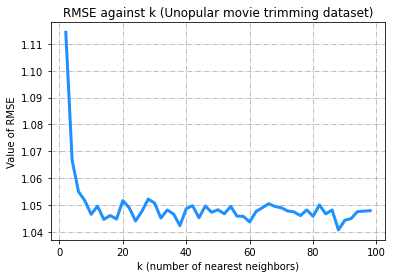

In [35]:
x = range(2,100,2)
plt.plot(x,rmse,color='dodgerblue',linewidth=3)
plt.grid(True,linestyle='-.')
plt.xlabel('k (number of nearest neighbors)')
plt.ylabel('Value of RMSE')
plt.title('RMSE against k (Unopular movie trimming dataset)')
print('The minimum average value of RMSE is:',min(rmse))

In [88]:
# train the dataset using Popular movie trimming
from surprise.model_selection import KFold
from surprise import accuracy
# define a cross-validation iterator
kf = KFold(n_splits=10)
sim_options = {
    'name': 'pearson',
    'user_based': 'True'
    }


# Construct a knn filter
rmse = []
for k in range(2,100,2):
    clf = KNNBasic(k=k, sim_options = sim_options)
    rmse_i = []
    for trainset, testset in kf.split(data):

        # train and test algorithm.
        clf.fit(trainset)
        testset_trim = HVMT(testset)
        predictions = clf.test(testset_trim)

        # Compute and print Root Mean Squared Error
        rmse_i.append(accuracy.rmse(predictions, verbose=True))
    rmse.append(np.mean(rmse_i))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7502
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.8038
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6215
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5915
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6659
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6652
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7314
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6631
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6488
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5446
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5869
Computing 

Done computing similarity matrix.
RMSE: 1.6158
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5712
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5393
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5463
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5586
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5637
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5835
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5877
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6519
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5382
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6702
Computing the pearson similarity matrix...
Done compu

RMSE: 1.5676
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4969
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6351
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5899
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6600
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4919
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6867
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5972
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6029
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4923
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6537
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.57

Done computing similarity matrix.
RMSE: 1.6563
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6093
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5327
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4926
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5462
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5557
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4870
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6043
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5217
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5973
Computing the pearson similarity matrix...
Done compu

RMSE: 1.5558
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6631
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6961
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5712
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6676
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6574
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5512
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6036
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5671
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5574
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5498
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.60

Done computing similarity matrix.
RMSE: 1.6667
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5520
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6033
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5212
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5076
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6267
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5639
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6204
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5209
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6036
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6046
Computing the pearson similarity matrix...
Done compu

The minimum average value of RMSE is: 1.53843749095183


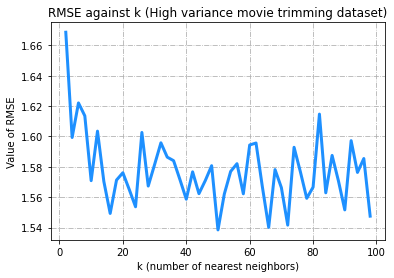

In [89]:
x = range(2,100,2)
plt.plot(x,rmse,color='dodgerblue',linewidth=3)
plt.grid(True,linestyle='-.')
plt.xlabel('k (number of nearest neighbors)')
plt.ylabel('Value of RMSE')
plt.title('RMSE against k (High variance movie trimming dataset)')
print('The minimum average value of RMSE is:',min(rmse))

In [67]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
from surprise.model_selection import train_test_split
%matplotlib inline

In [68]:
def get_roc_params(predictions ,thresholds):
    true_ratings = [getattr(pred, 'r_ui') for pred in predictions]
    estimated_rating = [getattr(pred, 'est') for pred in predictions]
    fpr = {}
    tpr = {}
    threshs = {}
    for i, thresh in enumerate(thresholds):
        true_ratings_bins = [1 if r > thresh else 0 for r in true_ratings]
        threshs[i] = thresh
        fpr[i], tpr[i], thresholdi = metrics.roc_curve(true_ratings_bins, estimated_rating)
        plot_roc(fpr[i], tpr[i], thresh)

        T_func = (1-fpr[i]) + tpr[i]
        ix = np.argmax(T_func)
        best_thresh = thresholdi[ix]
        print('Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=%f' % (best_thresh))
    

def plot_roc(fpr, tpr, thresh, file_name=None):
    fig, ax = plt.subplots()
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, color = 'r', label='Area Under Curve (AUC) = {}'.format(roc_auc))
    ax.grid(color='0.7', linestyle='--', linewidth=0.8)

    ax.set_xlabel('False Positive Rate', size=15)
    ax.set_ylabel('True Positive Rate', size=15)
    ax.legend(loc="lower right")
    plt.title('Threshold  = {}'.format(thresh), size=15)
    plt.show()
     

Computing the pearson similarity matrix...
Done computing similarity matrix.


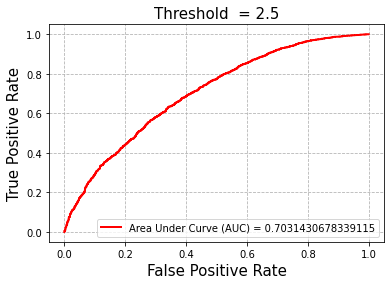

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.484395


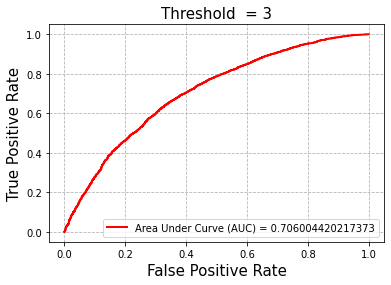

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.616234


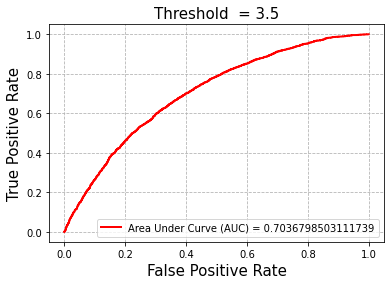

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.653538


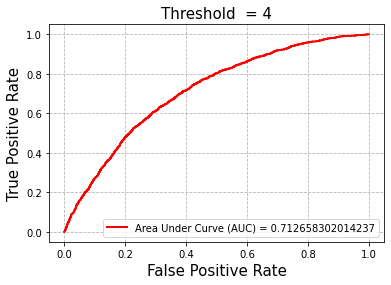

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.737299


In [71]:
# ROC Curves for Popular Movie Trim dataset

thresholds = [2.5, 3, 3.5, 4]
clf = KNNBasic(k=20, sim_options = sim_options)
trainset, testset = train_test_split(data, test_size=0.1,shuffle=True)
clf.fit(trainset)
testset_trim = PMT(testset)
predictions_rmse = clf.test(testset_trim)
get_roc_params(predictions_rmse ,thresholds)

Computing the pearson similarity matrix...
Done computing similarity matrix.


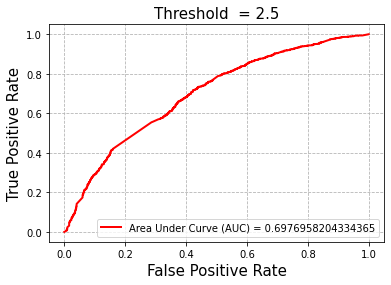

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.111649


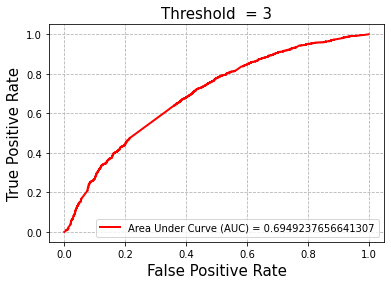

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.286664


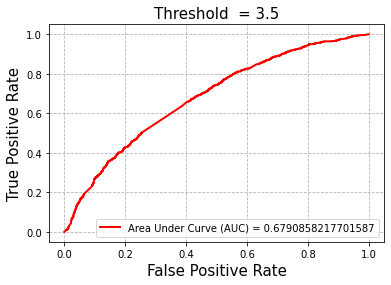

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.468847


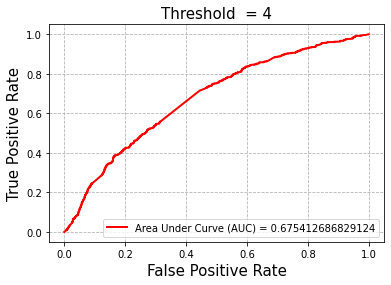

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.501107


In [73]:
# ROC Curves for Unpopular Movie Trim dataset

thresholds = [2.5, 3, 3.5, 4]
clf = KNNBasic(k=20, sim_options = sim_options)
trainset, testset = train_test_split(data, test_size=0.1,shuffle=True)
clf.fit(trainset)
testset_trim = UMT(testset)
predictions_rmse = clf.test(testset_trim)
get_roc_params(predictions_rmse ,thresholds)

Computing the pearson similarity matrix...
Done computing similarity matrix.


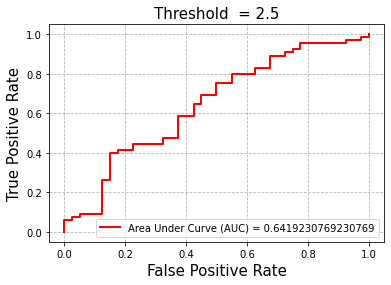

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.285867


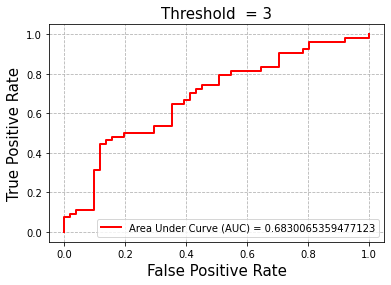

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.793842


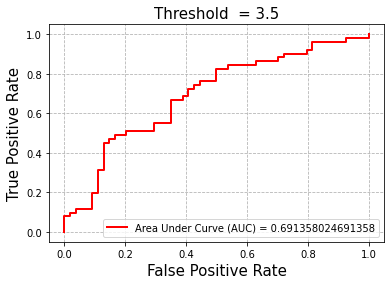

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.714765


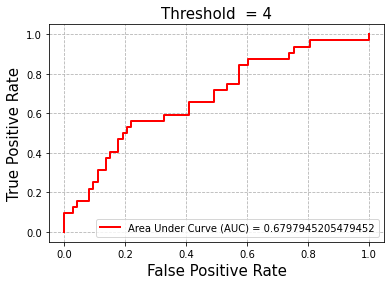

Maximizing the sum of specificity (1-FPR) and sensitivity (TPR) : Best Threshold=3.714765


In [90]:
# ROC Curves for High Variance Movie Trim dataset

thresholds = [2.5, 3, 3.5, 4]
clf = KNNBasic(k=20, sim_options = sim_options)
trainset, testset = train_test_split(data, test_size=0.1,shuffle=True)
clf.fit(trainset)
testset_trim = HVMT(testset)
predictions_rmse = clf.test(testset_trim)
get_roc_params(predictions_rmse ,thresholds)